# Comparison of the analysis of real data by Megan and Kraken

While for previous test I used only simulated datasets with known proportions, this time I compared the results of the analysis of Data by Megan and Kraken for a real dataset --> **181011_B18926_MTcapAllmam** 

## 1. Settings ##
### Used Pipelines ###
- Snakemake 1: The original Pipeline as used by everyone
- Snakemake 2: The Pipeline altered by me to allow unmapped reads to be analyzed
- Nextflow: My Version of the Nextflow-Pipeline (see gitlab:https://vcs.eva.mpg.de/merlin_szymanski/nextflow_pipeline, branch: "devel"), which handels the sequences in the mapping process the same as the Snakemake pipeline. See https://docs.google.com/presentation/d/1AD7oqvxZSXD9l6pNtoRxFMj5ANIlMTSY0RXKZhyAw-s/edit#slide=id.g6de0e02e7f_0_23 for better explaination. Here Kraken was used with Kmersize 22

### Filters ###
For both the taxa assigned by kraken and megan I used a threshold of 1% of the assigned reads to keep the family for downstream analysis. The Nextflow-Pipeline was implemented with a Kraken-Filter of 0.1.

### Analysed Runs ### 

|Name of Run | Pipeline | Deduplication? | Discard Unmapped? | Comments |
| --- | --- | --- | --- | --- |
|MEGAN | Snakemake 2 | y | n | see Apendix
|MEGAN_v2 | Snakemake 1 | y | y | 1:1 re-analysis of 181011...
|MEGAN_v3 | Snakemake 2 | y | n | see Apendix
|Kraken | Nextflow | n | n |
|Kraken_deduped | Nextflow | y | n | This function exists, so why not?
|181011_B...Allmam| Snakemake 1 | y | y | Taken from mnt/sediment/analyzed_runs/
 
MEGAN and MEGAN_v3 where dropped in the downstream analysis, because there where no "aligned"-directories after the analysis. I assume, that the huge amount of reads was to much to handle? So in the end we compare Kraken with the Megan-results from the deduplicated pipeline Snakemake 1.  
## 2. The Summary-Script ##

In [1]:
import os
from pathlib import *
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import shutil
import random

In [45]:
#Make sure to be in /mnt/scratch/merlin/Dec19/Real_data/
try:
    data = pd.read_csv("Count_data.csv", index_col=0)
except FileNotFoundError:
    """Now count the stuff"""
    width = shutil.get_terminal_size()[0]
    
    exclude = ['work','analyzed','aligned','split','pseudouniq','filter_deam3or5'] #dont walk through the conda-jungle
    data = pd.DataFrame(index = ['Family','Origin','Before_BWA','After_BWA'])

    for root,dirs,files in os.walk('.'):
        dirs[:]=[d for d in dirs if d not in exclude]
        p = Path(root)
        #find all {family} folders
        if(len([x for x in p.glob("*.bam")])>0 and len(p.parts)>1):
            family = p.parts[-1]
            origin = p.parts[1]
            before_bwa = []
            after_bwa = []
            #count assigned reads before BWA
            for bam in p.glob("*.bam"):
                print(f"Opening: {bam}".ljust(width," "), end="\r")
                samfile = pysam.AlignmentFile(f"{bam}", "rb", check_sq=False)
                before_bwa.extend([x.query_name for x in samfile])

            #Count the aligned reads after BWA
            if('aligned' in os.listdir(p)):
                p = p/"aligned"
                for bam in p.glob("*bam"):
                    print(f"Opening: {bam}".ljust(width," "), end="\r")
                    samfile = pysam.AlignmentFile(f"{bam}", "rb", check_sq=False)
                    after_bwa.extend([x.query_name for x in samfile])

            #Add the data to the dataframe
            data[len(data.columns)]=[family,origin,len(set(before_bwa)),len(set(after_bwa))]
    data.to_csv("Count_data.csv")

In [46]:
#Transform data and change type
data = data.T.astype({"Before_BWA":"int64", "After_BWA":"int64"})
data2 = data.copy()

data = data[(data.Origin != "MEGAN")&(data.Origin != "MEGAN_v3")]
data["Sum"] = data["Origin"].map(lambda x: data[data["Origin"]==x]["After_BWA"].sum())
data["Percentage"] = data["After_BWA"]/data["Sum"]

In [35]:
#Look at the data
data[(data["Percentage"]>0.01)].sort_values(["Origin","Percentage"]).drop("Sum", axis=1).set_index(["Origin","Family"])#.to_csv("Sorted_by_percentage_01.csv")

Before_BWA  After_BWA  Percentage
Origin                    Family                                           
181011_B18926_MTcapAllmam Ursidae               2529       2521    0.011416
                          Hominidae             3699       3679    0.016660
                          Elephantidae          3787       3770    0.017072
                          Rhinocerotidae        4228       4227    0.019142
                          Cervidae              9244       9176    0.041554
                          Equidae              13340      13328    0.060356
                          Canidae              15371      15366    0.069585
                          Bovidae              77856      77823    0.352423
                          Hyaenidae            89067      89059    0.403305
Kraken                    Hominidae            76877      74369    0.016490
                          Elephantidae        108468     104632    0.023200
                          Rhinocerotidae      111193     108221    0.023996
                          Cervidae            182754     176319    0.039095
                          Canidae             242164     236922    0.052532
                          Equidae             283969     277050    0.061430
                          Bovidae            1394712    1367856    0.303292
                          Hyaenidae          1915142    1880849    0.417037
Kraken_dedup              Rhinocerotidae       31250       3704    0.012335
                          Hominidae            17045       6219    0.020710
                          Canidae              64508       8193    0.027284
                          Elephantidae         32546       9830    0.032735
                          Cervidae             55151      13992    0.046595
                          Equidae              66239      15926    0.053035
                          Hyaenidae           532364      75816    0.252475
                          Bovidae             372455     153274    0.510418
MEGAN_v2                  Ursidae               2411       2403    0.010893
                          Hominidae             3699       3679    0.016678
                          Elephantidae          3786       3770    0.017090
                          Rhinocerotidae        4228       4227    0.019162
                          Cervidae              9244       9176    0.041597
                          Equidae              13341      13329    0.060424
                          Canidae              15238      15233    0.069055
                          Bovidae              77874      77841    0.352875
                          Hyaenidae            89069      89061    0.403738

In [48]:
#make a dict with random colors --> same color for each family
color_dict = {k:tuple(random.random() for _ in range(3)) for k in set(data.loc[:,"Family"])}

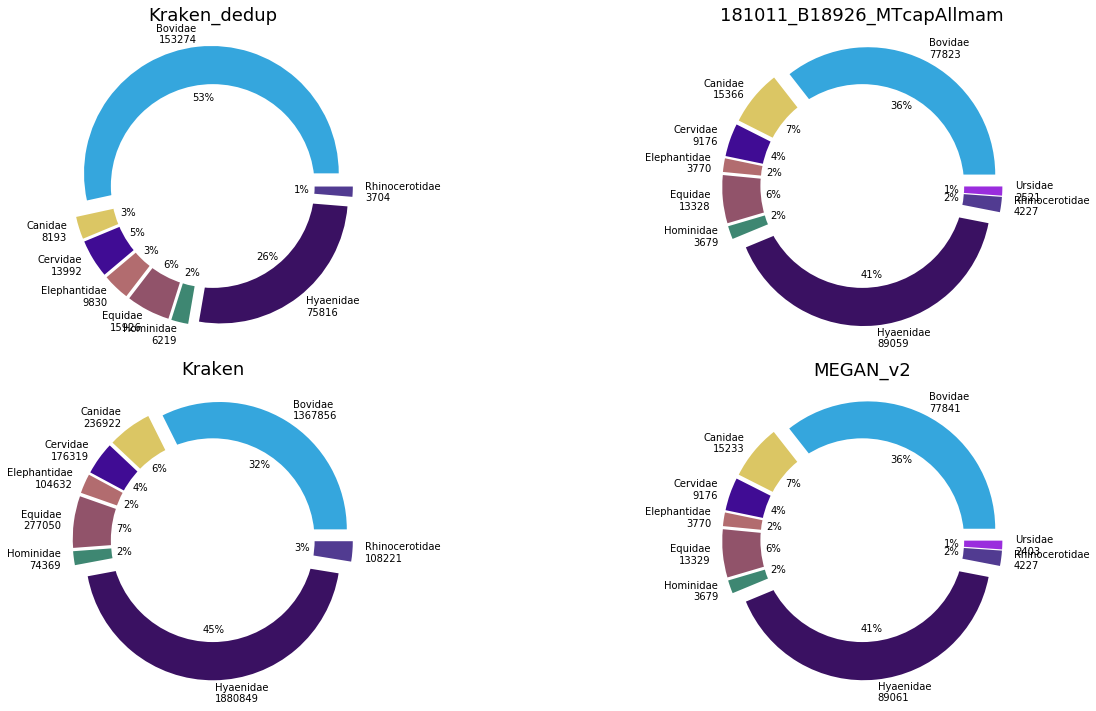

In [52]:
#print pie-chart with the families
fam_data = data[data["Percentage"]>0.01]

plt.figure(figsize=(20,10))

a1 = plt.subplot2grid((2,2),(0,0),rowspan=1, colspan=1)
a2 = plt.subplot2grid((2,2),(0,1),rowspan=1, colspan=1)
a3 = plt.subplot2grid((2,2),(1,0),rowspan=1, colspan=1)
a4 = plt.subplot2grid((2,2),(1,1),rowspan=1, colspan=1)
subplot_dict = {0:a1, 1:a2, 2:a3, 3:a4}

counter = 0
for origin in set(fam_data["Origin"]):
    ax = subplot_dict[counter]
    sub_data = fam_data.loc[fam_data.Origin == origin, :].sort_values("Family")
    sub_data["Label"] = sub_data["Family"].str.cat(sub_data["After_BWA"].astype(str), sep="\n")
    
    ax.pie(sub_data["After_BWA"],labels=sub_data["Label"],autopct="%1.f%%", explode=[0.1 for _ in range(len(sub_data))] ,colors=[color_dict[x] for x in sub_data["Family"]])
    ax.set_title(origin, fontdict={"fontsize":18})
    ax.add_artist(plt.Circle((0,0),0.8, fc="white"))
    
    counter += 1

plt.tight_layout()
plt.savefig("compare_piechart.png")

## 3. Diskussion ##
In my Opinion, the Kraken-Analysis looks pretty much the same as the Megan-Results, concerning the proportion of assigned families. It is strange, that the kraken_dedup differs so much from the rest, since all the megan-runs do a deduplication-step too. 
**Next Steps:**
 - Rerun, after applying the Kraken-filter (0.1)?
 - Discuss!! What are the next steps

#### Appendix ####
Because I was interested, how the deduplicated versions of the discarded runs look like, I draw the charts for these ones too. However, I had to use the **Before_BWA** Column to calulate the proportions. Also note, that they are analyzed the same way, so they should be the same! 

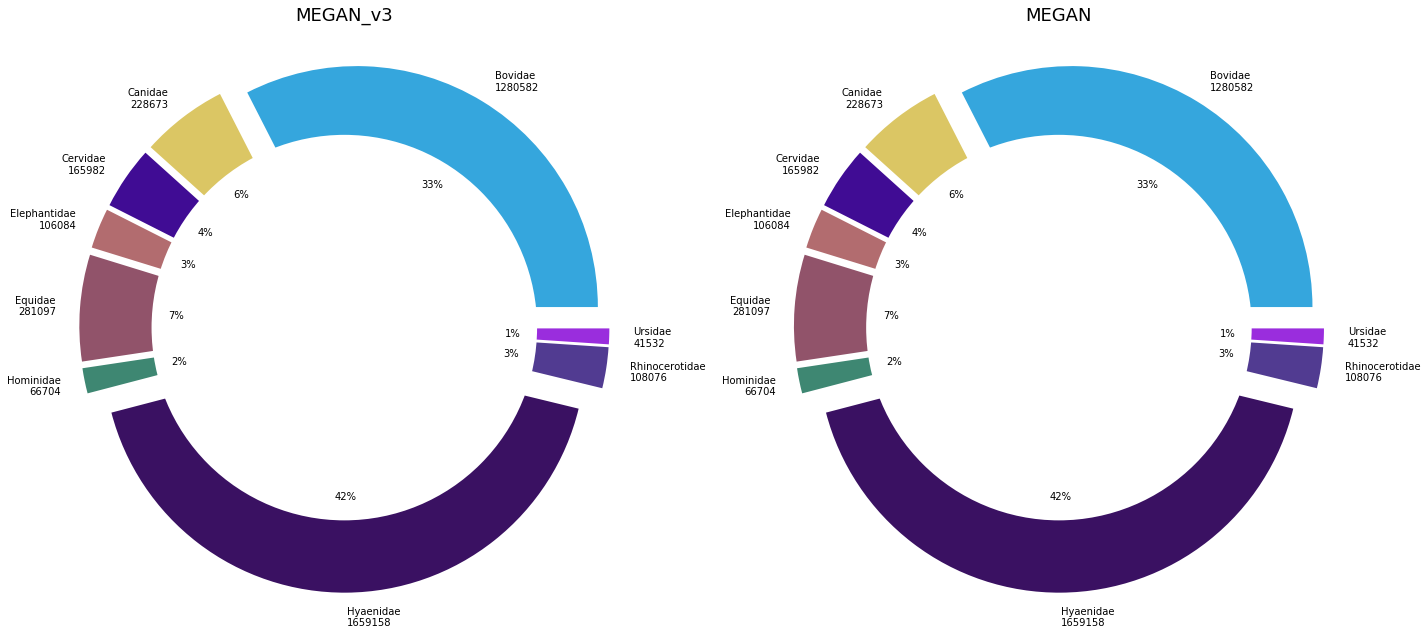

In [51]:
#Do the same for the data2
data2["Sum"] = data2["Origin"].map(lambda x: data2[data2["Origin"]==x]["Before_BWA"].sum())
data2["Percentage"] = data2["Before_BWA"]/data2["Sum"]

#print pie-chart with the families
fam_data = data2[(data2["Percentage"]>0.01)&(data2.Origin == "MEGAN")|(data2["Percentage"]>0.01)&(data2.Origin == "MEGAN_v3")]

plt.figure(figsize=(20,10))

a1 = plt.subplot2grid((1,2),(0,0),rowspan=1, colspan=1)
a2 = plt.subplot2grid((1,2),(0,1),rowspan=1, colspan=1)
subplot_dict = {0:a1, 1:a2}

counter = 0
for origin in set(fam_data["Origin"]):
    ax = subplot_dict[counter]
    sub_data = fam_data.loc[fam_data.Origin == origin, :].sort_values("Family")
    sub_data["Label"] = sub_data["Family"].str.cat(sub_data["Before_BWA"].astype(str), sep="\n")
    
    ax.pie(sub_data["Before_BWA"],labels=sub_data["Label"],autopct="%1.f%%", explode=[0.1 for _ in range(len(sub_data))] ,colors=[color_dict[x] for x in sub_data["Family"]])
    ax.set_title(origin, fontdict={"fontsize":18})
    ax.add_artist(plt.Circle((0,0),0.8, fc="white"))
    
    counter += 1

plt.tight_layout()
#plt.savefig("compare_piechart.png")